In [27]:
# few packages to import
import sympy as sy
import numpy as np
from sympy import init_session
init_session() 
la=np.linalg
%config IPCompleter.greedy=True
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # retina display

IPython console for SymPy 1.13.3 (Python 3.12.7-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.13.3/



## Design an insertion
We will now solve the problem of trasporting a given initial optical condition to a target optical function.
Typically we want to transport ($\beta_x$,$\alpha_x$, $\beta_y$, $\alpha_y$) to ($\beta_0$, $0$, $\beta_0$, $0$) (i.e. a **$\beta$-waist with round optics**).
An initial approach to this problem is to start solving a **FODO with initial condition**. So we ask ourself: if a enter a FODO with ($\beta_0$, $0$, $\beta_0$, $0$) what are the final solution of the $\beta$-functions?

We have to remember the transport equation
\begin{equation}
\underbrace{{\begin{pmatrix}
\beta(s_1)  &        -\alpha(s_1) \\
-\alpha(s_1)  & \gamma(s_1) 
\end{pmatrix}}}_{J(s_1)\ \Omega^{-1}}
 = M  
\underbrace{{\begin{pmatrix}
\beta(s_0)  &        -\alpha(s_0)\\
-\alpha(s_0) & \gamma(s_0)
\end{pmatrix}}}_{J(s_0)\ \Omega^{-1}}
\ M^T.
\end{equation}


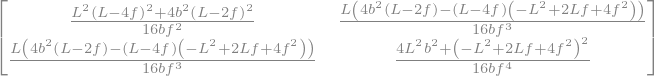

In [2]:
L=sy.Symbol('L', positive=True, real=True);
f=sy.Symbol('f', positive=True, real=True);

b=sy.Symbol('b', positive=True, real=True); # beta
#a=sy.Symbol('a', real=True); # alpha
#c=sy.Symbol('c', positive=True, real=True); # gamma


DRIFT=sy.Matrix([[1,L/2], [0,1]])

Q1=sy.Matrix([[1,0], [-1/f,1]])
Q2=sy.Matrix([[1,0], [1/f,1]])


Mlr=Q2@DRIFT@Q1@DRIFT
Mlr=sy.simplify(Mlr)

# Very important!
sigma0=sy.Matrix([[b,0], [0,1/b]])

sigma1=sy.simplify(Mlr@sigma0@Mlr.transpose())
sigma1

A very useful property is that we can reach the ($\beta_0$, $0$, $\beta_0$, $0$) starting from the just found solution (**BUT** inverting $\alpha$) using a  **symmetric configuration**. In other words:

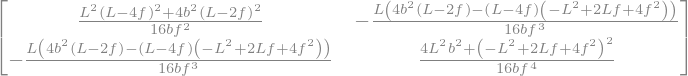

In [28]:
# PAY ATTENTION TO THE '-'
sigma1_inv=sy.Matrix([[sigma1[0],-sigma1[1]], [-sigma1[2],sigma1[3]]])
sigma1_inv


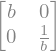

In [29]:
Mrl=DRIFT@Q1@DRIFT@Q2

sy.simplify(Mrl@sigma1_inv@Mrl.transpose())

# Using symmetry in Xsuite

Slicing line:   0%|          | 0/6 [00:00<?, ?it/s]

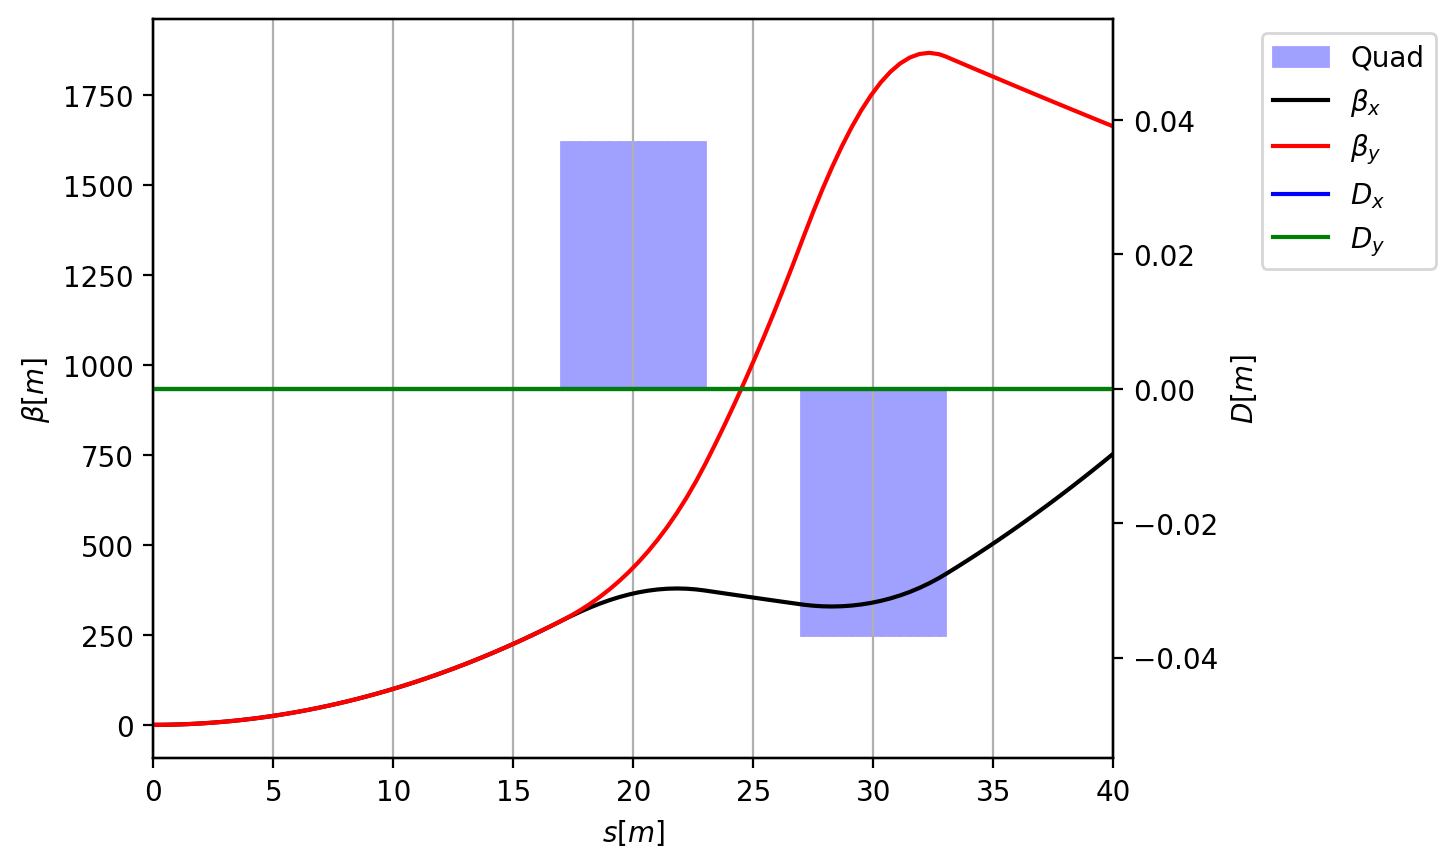

In [30]:
import xtrack as xt
env = xt.Environment()
f=15
l_quad=6
beta0 = 1 
env['k1']= 1/f/l_quad
line = env.new_line(name='myline', components=[
    env.new('q1', xt.Quadrupole, length=l_quad, k1='k1', at=20),  # Create an element
    env.new('q2', xt.Quadrupole, length=l_quad, k1='-k1', at=30),  # Create another element
    env.new('end', xt.Marker, at=40)  # Create another element
     ])
line.cut_at_s(np.linspace(0, 40, 100))
line.particle_ref = xt.Particles(p0c=7e12, mass0=xt.PROTON_MASS_EV) 
my_twiss = line.twiss4d(betx=beta0, bety=beta0)
my_twiss.plot()

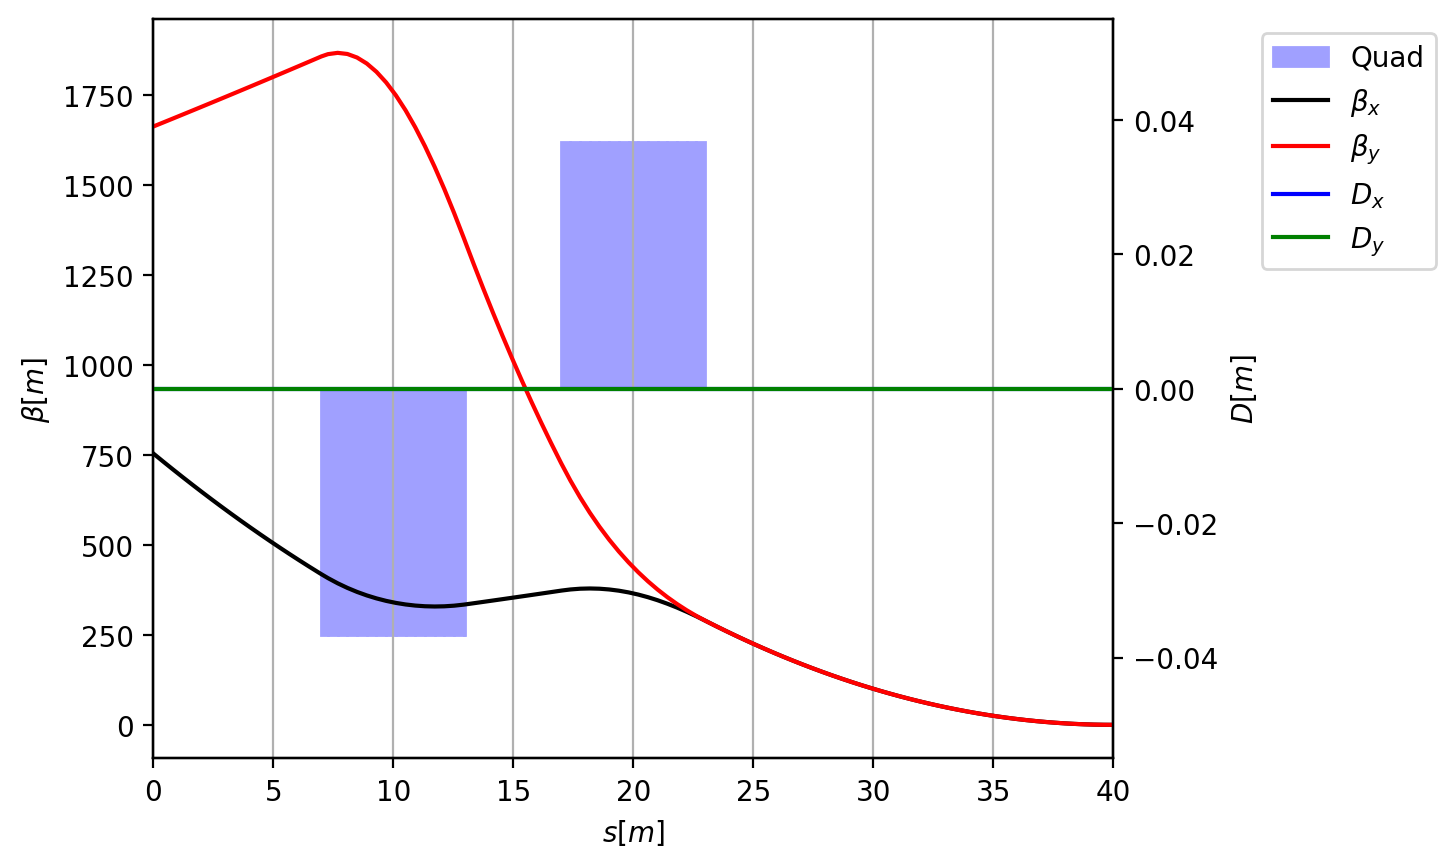

In [31]:
line_reflected = -line
line_reflected.particle_ref = xt.Particles(p0c=7e12, mass0=xt.PROTON_MASS_EV) 
line_reflected.twiss4d(betx=my_twiss['betx',-1], 
                bety=my_twiss['bety',-1], 
                alfx=-my_twiss['alfx',-1],
                alfy=-my_twiss['alfy',-1]).plot()

In [32]:
import xtrack as xt
env = xt.Environment()
from ipywidgets import interactive


# Define a variable in the environment
def f(f, l_quad, beta0):
    k1= 1/f/l_quad
    line = env.new_line(name='myline', components=[
        env.new('q1', xt.Quadrupole, length=l_quad, k1=k1, at=20),  # Create an element
        env.new('q2', xt.Quadrupole, length=l_quad, k1=-k1, at=30),  # Create another element
        env.new('end', xt.Marker, at=40)  # Create another element
         ])
    line.cut_at_s(np.linspace(0, 40, 100))
    line.particle_ref = xt.Particles(p0c=7e12, mass0=xt.PROTON_MASS_EV) 
    line.twiss4d(betx=beta0, bety=beta0).plot()
    plt.show()

interactive_plot = interactive(f, f=(10, 100, 1), l_quad=(0.1 ,10,.1),beta0=(1,2,.01),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot

interactive(children=(IntSlider(value=55, description='f', min=10), FloatSlider(value=5.0, description='l_quad…

Slicing line:   0%|          | 0/6 [00:00<?, ?it/s]

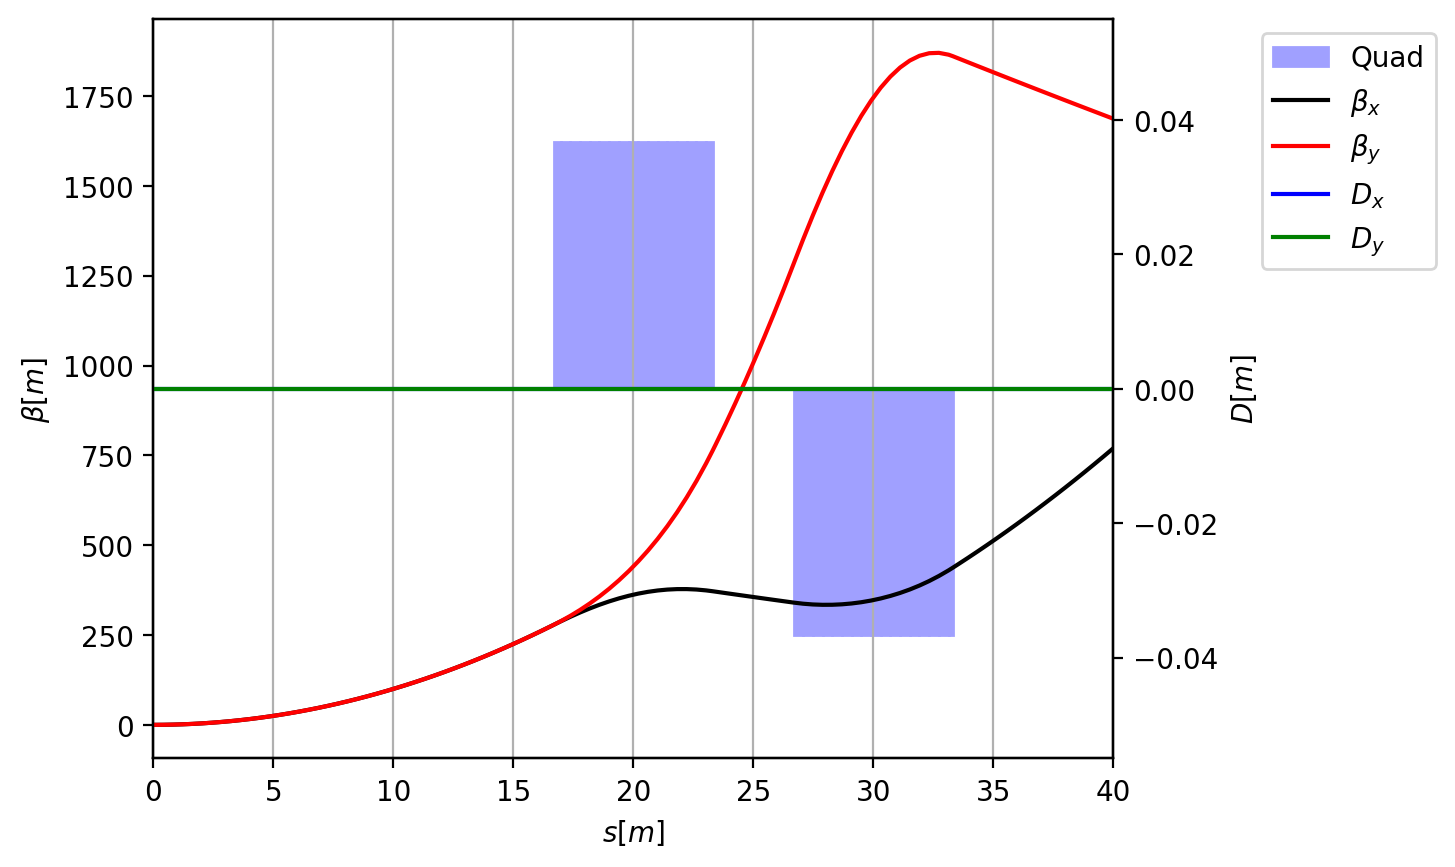

In [33]:
f(15, 6.60, 1)

In [34]:
# A symmetric doublet

def f(f, l_quad, beta0):
    k1= 1/f/l_quad
    line = env.new_line(name='myline', components=[
    env.new('start', xt.Marker, at = -40, from_ ='ip'),
    env.new('q1l', xt.Quadrupole, length=l_quad, k1=k1, at=-20, from_ ='ip'),  # Create an element
    env.new('q2l', xt.Quadrupole, length=l_quad, k1=-k1, at=-30, from_ ='ip'),
    env.new('ip', xt.Marker, at = 40),
    env.new('q1r', xt.Quadrupole, length=l_quad, k1=k1, at=20, from_ ='ip'),  # Create an element
    env.new('q2r', xt.Quadrupole, length=l_quad, k1=-k1, at=30, from_ ='ip'),  # Create another element
    env.new('end', xt.Marker, at=40, from_ ='ip')  # Create another element
     ])
    line.particle_ref = xt.Particles(p0c=7e12, mass0=xt.PROTON_MASS_EV) 
    
    half_twiss = line.twiss4d(betx=beta0, bety=beta0, start='ip', end='end')
    line.cut_at_s(np.linspace(0, 80, 100))
    
    line.twiss4d(betx=half_twiss['betx','end'], 
                bety=half_twiss['bety','end'], 
                alfx=-half_twiss['alfx','end'],
                alfy=-half_twiss['alfy','end'],).plot()
    plt.show()

interactive_plot = interactive(f, f=(10, 100, 1), l_quad=(0.1 ,10,.1),beta0=(1,2,.01),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot

interactive(children=(IntSlider(value=55, description='f', min=10), FloatSlider(value=5.0, description='l_quad…

Slicing line:   0%|          | 0/13 [00:00<?, ?it/s]

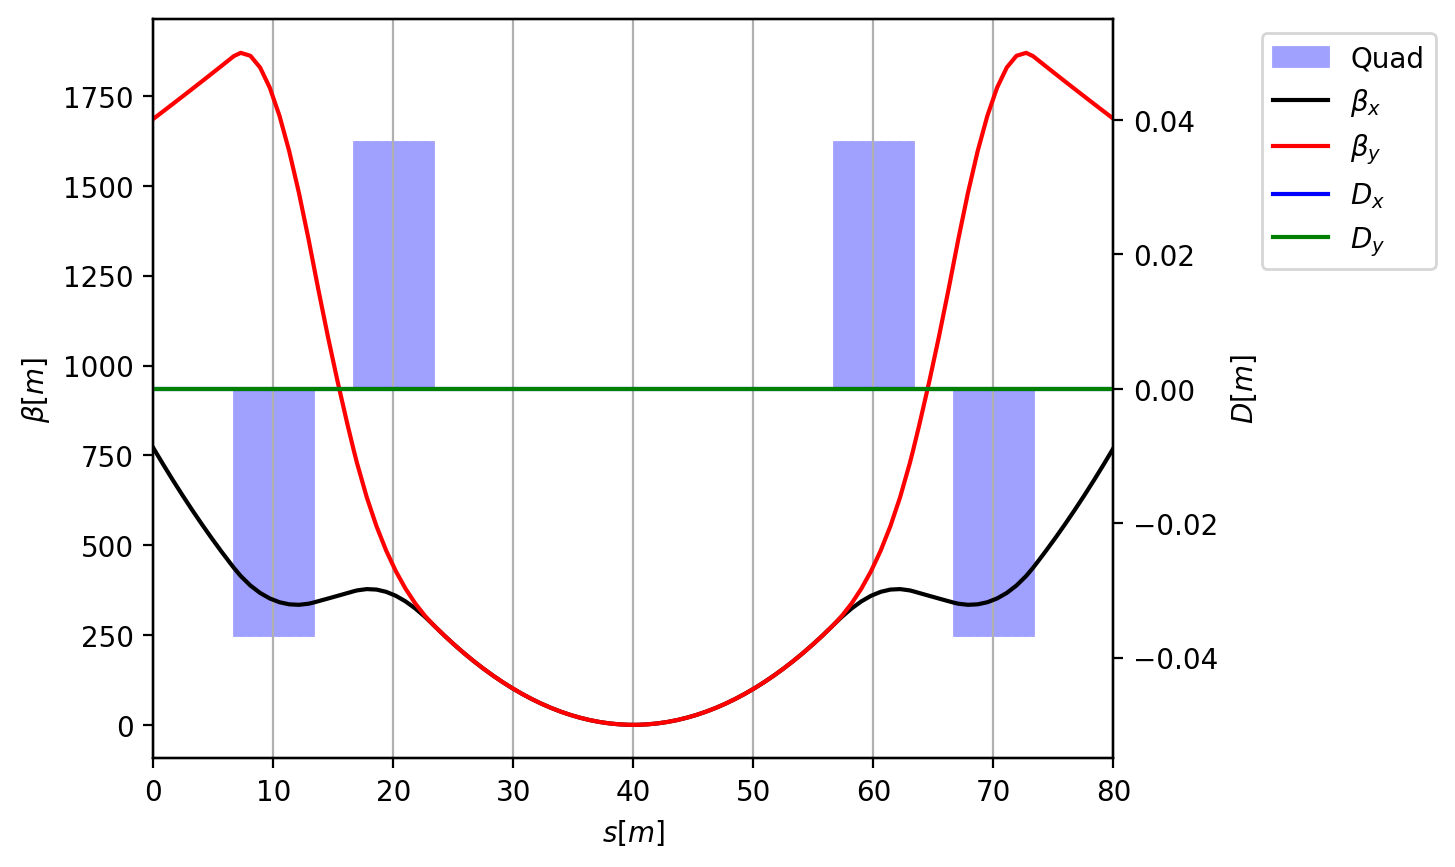

In [11]:
f(15, 6.6, 1)

### A symmetric doublet

### The anti-symmetric doublet

In [35]:
# Define a variable in the environment
def f(f, l_quad, beta0):
    k1= 1/f/l_quad
    line = env.new_line(name='myline', components=[
    env.new('start', xt.Marker, at = -40, from_ ='ip'),
    env.new('q1l', xt.Quadrupole, length=l_quad, k1=-k1, at=-20, from_ ='ip'),  # Create an element
    env.new('q2l', xt.Quadrupole, length=l_quad, k1=+k1, at=-30, from_ ='ip'),
    env.new('ip', xt.Marker, at = 40),
    env.new('q1r', xt.Quadrupole, length=l_quad, k1=k1, at=20, from_ ='ip'),  # Create an element
    env.new('q2r', xt.Quadrupole, length=l_quad, k1=-k1, at=30, from_ ='ip'),  # Create another element
    env.new('end', xt.Marker, at=40, from_ ='ip')  # Create another element
     ])
    line.particle_ref = xt.Particles(p0c=7e12, mass0=xt.PROTON_MASS_EV) 
    
    half_twiss = line.twiss4d(betx=beta0, bety=beta0, start='ip', end='end')
    line.cut_at_s(np.linspace(0, 80, 100))
    
    line.twiss4d(bety=half_twiss['betx','end'], 
                betx=half_twiss['bety','end'], 
                alfy=-half_twiss['alfx','end'],
                alfx=-half_twiss['alfy','end'],).plot()
    plt.show()

interactive_plot = interactive(f, f=(10, 100, 1), l_quad=(0.1 ,10,.1),beta0=(1,2,.01),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot

interactive(children=(IntSlider(value=55, description='f', min=10), FloatSlider(value=5.0, description='l_quad…

Slicing line:   0%|          | 0/11 [00:00<?, ?it/s]

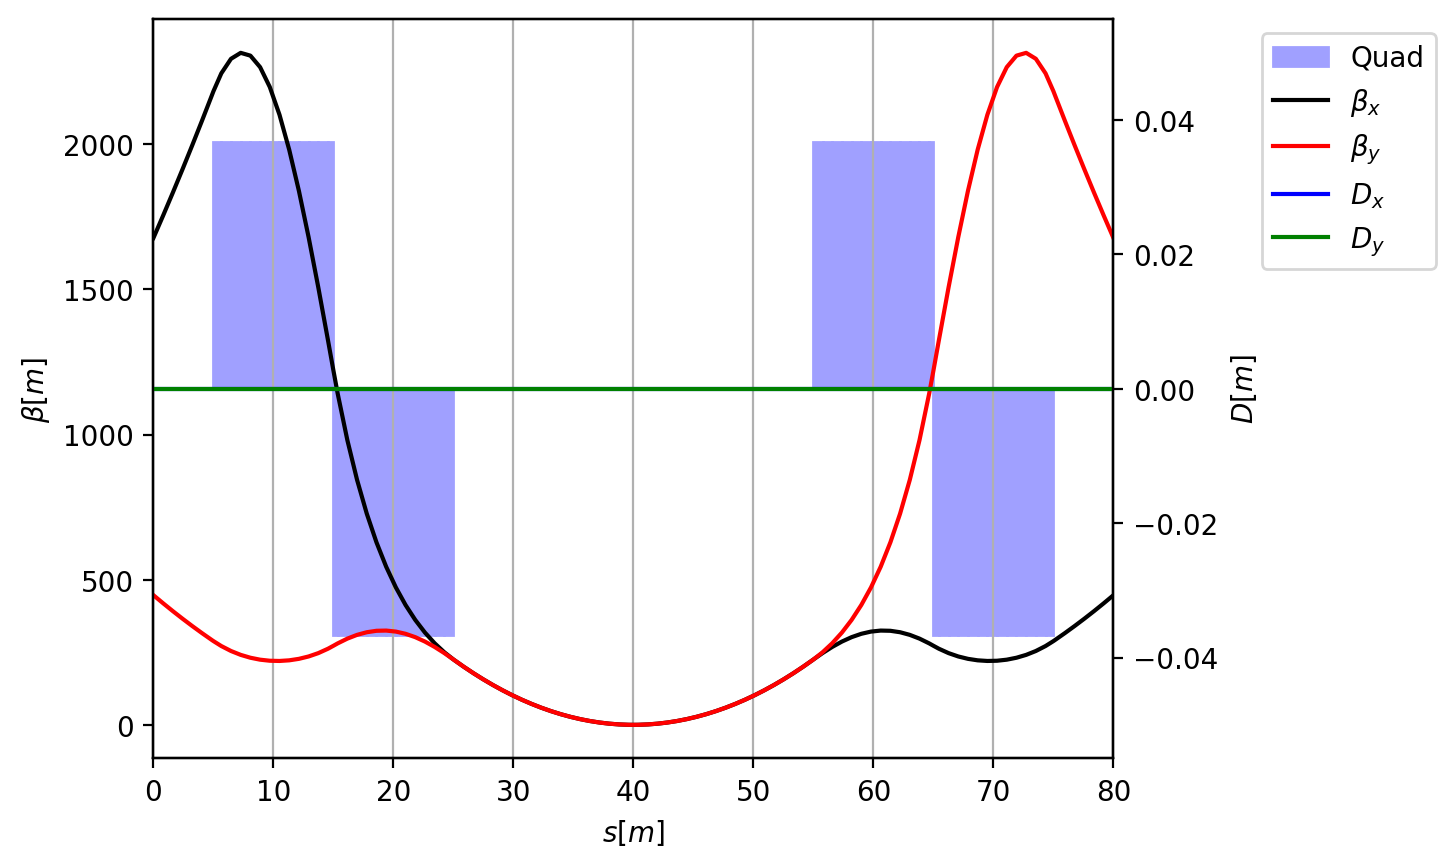

In [13]:
f(10, 10, 1)

Slicing line:   0%|          | 0/11 [00:00<?, ?it/s]

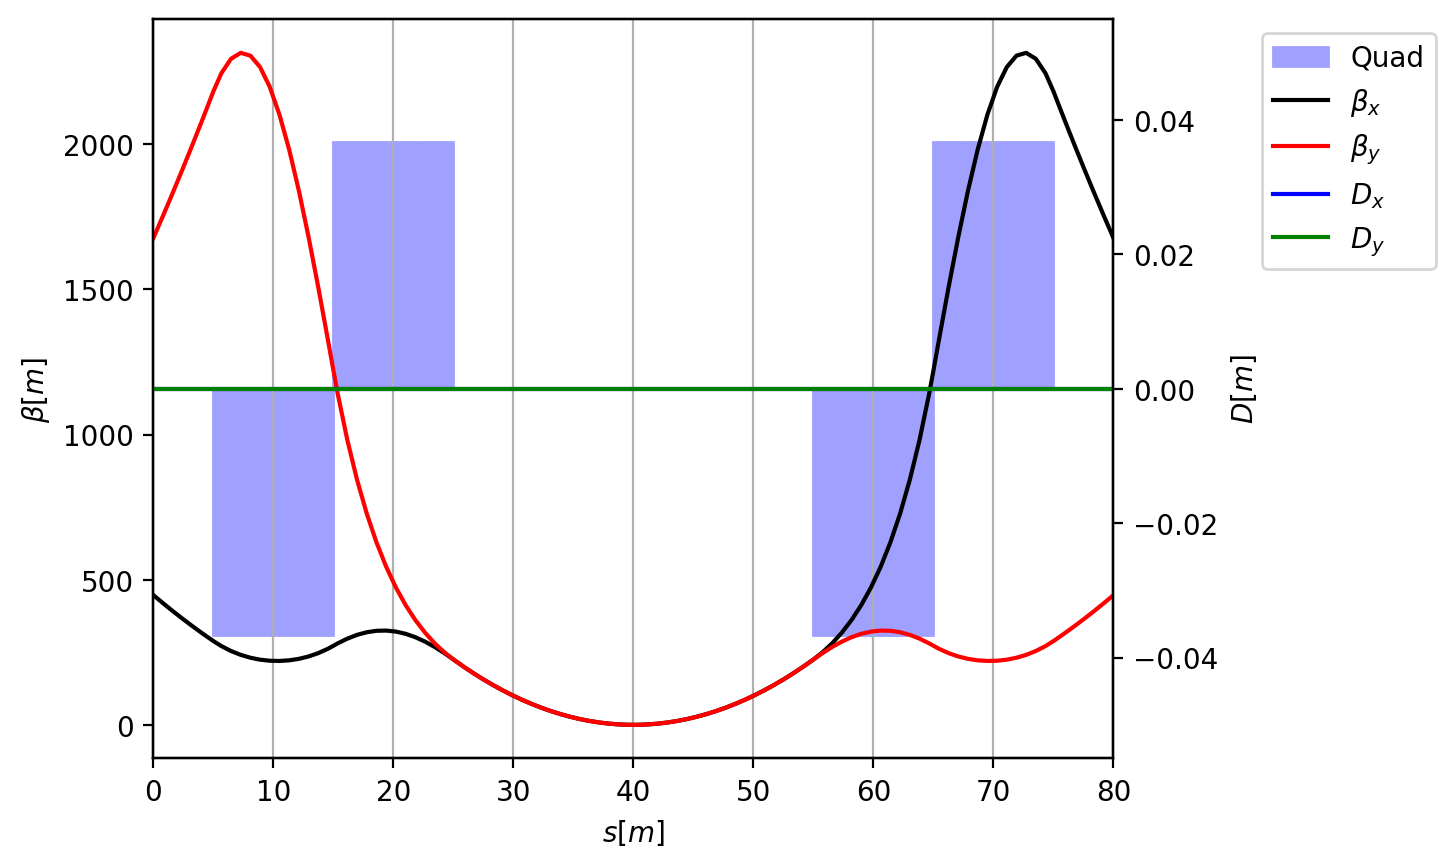

In [14]:
#note the inversion x-y 
f(-10, 10, 1)

### From the doublet to triplet final focusing

In [36]:
# Define a variable in the environment
def f(f, l_quad, beta0):
    k1= 1/f/l_quad
    line = env.new_line(name='myline', components=[
        env.new('q1', xt.Quadrupole, length=l_quad, k1=k1, at=20),  # Create an element
        env.new('q2a', xt.Quadrupole, length=l_quad, k1=-k1, at=30),  # Create another element
         env.new('q2b', xt.Quadrupole, length=l_quad, k1=-k1, at=40),
         env.new('q3', xt.Quadrupole, length=l_quad, k1=+k1, at=50),
        env.new('end', xt.Marker, at=60)  # Create another element
         ])
    line.cut_at_s(np.linspace(0, 60, 100))
    line.particle_ref = xt.Particles(p0c=7e12, mass0=xt.PROTON_MASS_EV) 
    line.twiss4d(betx=beta0, bety=beta0).plot()
    plt.show()

interactive_plot = interactive(f, f=(10, 100, 1), l_quad=(0.1 ,10,.1),beta0=(1,2,.01),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot

interactive(children=(IntSlider(value=55, description='f', min=10), FloatSlider(value=5.0, description='l_quad…

Slicing line:   0%|          | 0/10 [00:00<?, ?it/s]

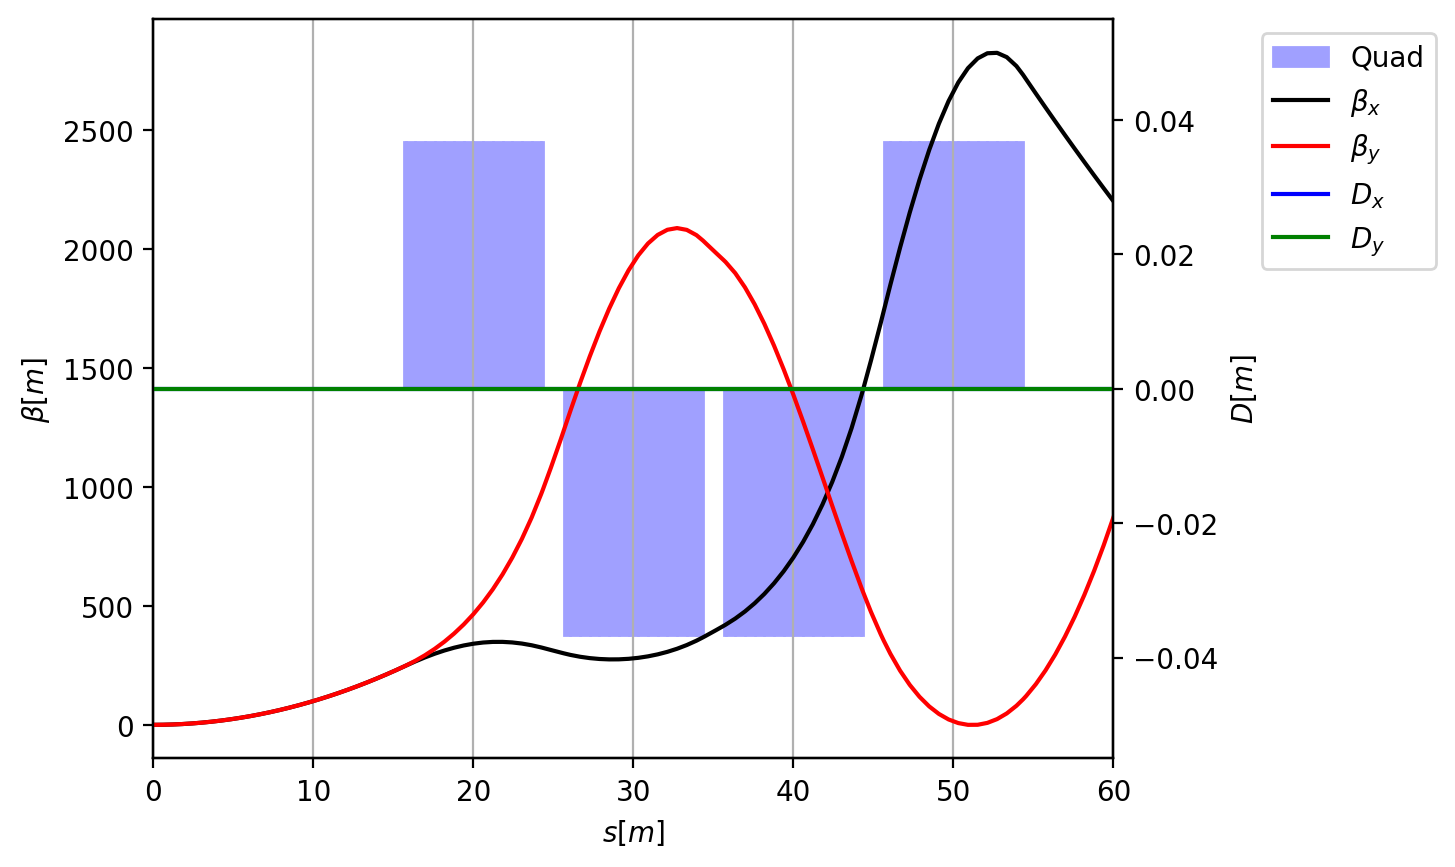

In [37]:
f(12, 8.7, 1)

### Symmetric triplets

In [39]:
def f(f, l_quad, beta0):
    k1= 1/f/l_quad
    line = env.new_line(name='myline', components=[
    env.new('start', xt.Marker, at = -60, from_ ='ip'),
    env.new('q3l', xt.Quadrupole, length=l_quad, k1=-k1, at=-50, from_ ='ip'),  # Create an element
    env.new('q2bl', xt.Quadrupole, length=l_quad, k1=k1, at=-40, from_ ='ip'),  # Create an element
    env.new('q2al', xt.Quadrupole, length=l_quad, k1=k1, at=-30, from_ ='ip'),  # Create an element
    env.new('q1l', xt.Quadrupole, length=l_quad, k1=-k1, at=-20, from_ ='ip'),
    env.new('ip', xt.Marker, at = 60),
    env.new('q1r', xt.Quadrupole, length=l_quad, k1=-k1, at=20, from_ ='ip'),  # Create an element
    env.new('q2ar', xt.Quadrupole, length=l_quad, k1=+k1, at=30, from_ ='ip'),  # Create another element
    env.new('q2br', xt.Quadrupole, length=l_quad, k1=+k1, at=40, from_ ='ip'),  # Create another element
    env.new('q3r', xt.Quadrupole, length=l_quad, k1=-k1, at=50, from_ ='ip'),  # Create another element

    env.new('end', xt.Marker, at=60, from_ ='ip')  # Create another element
     ])
    line.particle_ref = xt.Particles(p0c=7e12, mass0=xt.PROTON_MASS_EV) 
    
    half_twiss = line.twiss4d(betx=beta0, bety=beta0, start='ip', end='end')
    line.cut_at_s(np.linspace(0, 160, 100))
    
    line.twiss4d(betx=half_twiss['betx','end'], 
                bety=half_twiss['bety','end'], 
                alfx=-half_twiss['alfx','end'],
                alfy=-half_twiss['alfy','end'],).plot()
    plt.show()

interactive_plot = interactive(f, f=(10, 100, 1), l_quad=(0.1 ,10,.1),beta0=(1,2,.01),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot

interactive(children=(IntSlider(value=55, description='f', min=10), FloatSlider(value=5.0, description='l_quad…

Slicing line:   0%|          | 0/21 [00:00<?, ?it/s]

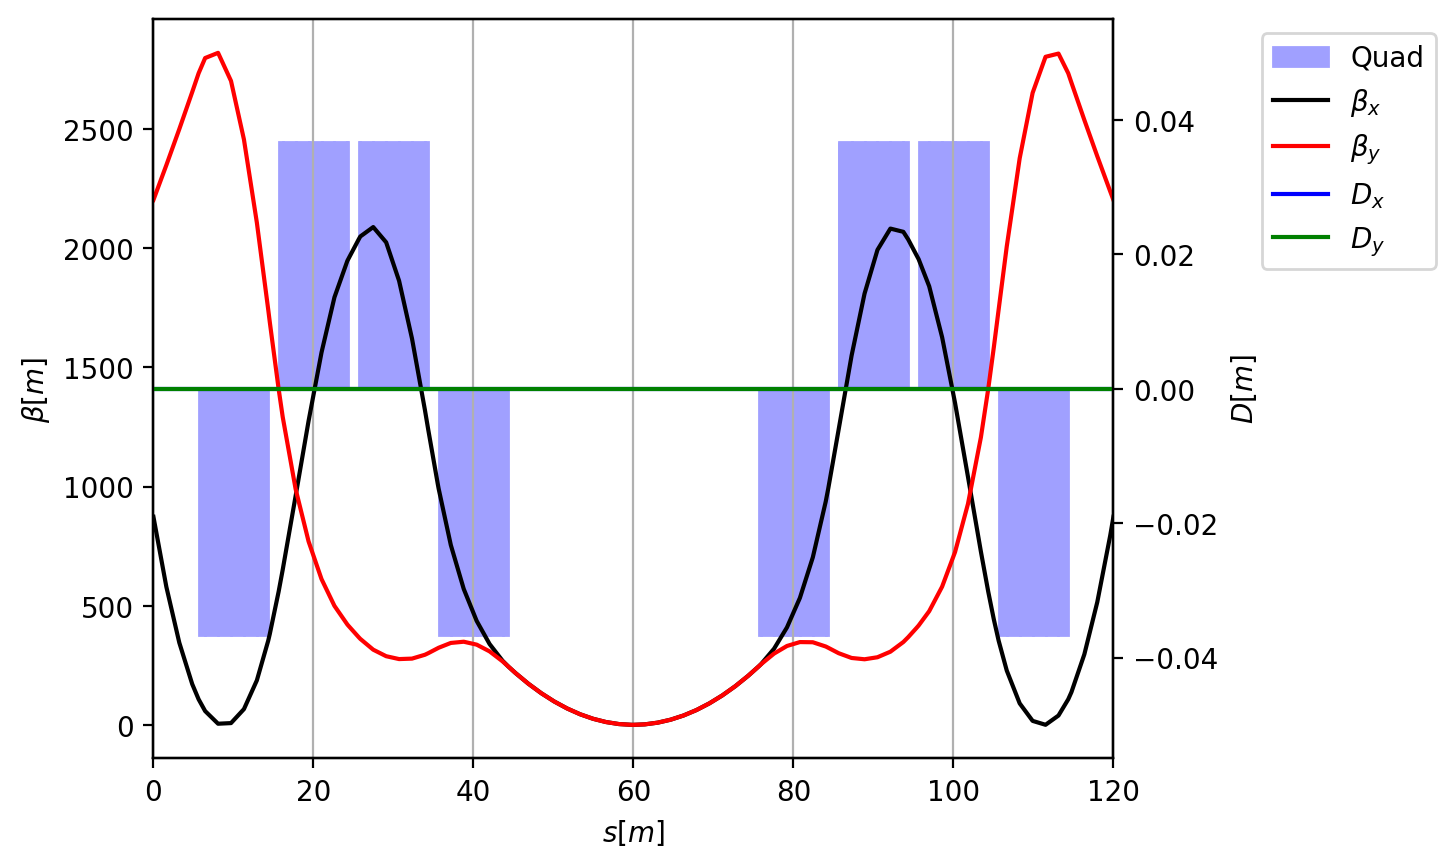

In [40]:
f(12, 8.7, 1)

Slicing line:   0%|          | 0/21 [00:00<?, ?it/s]

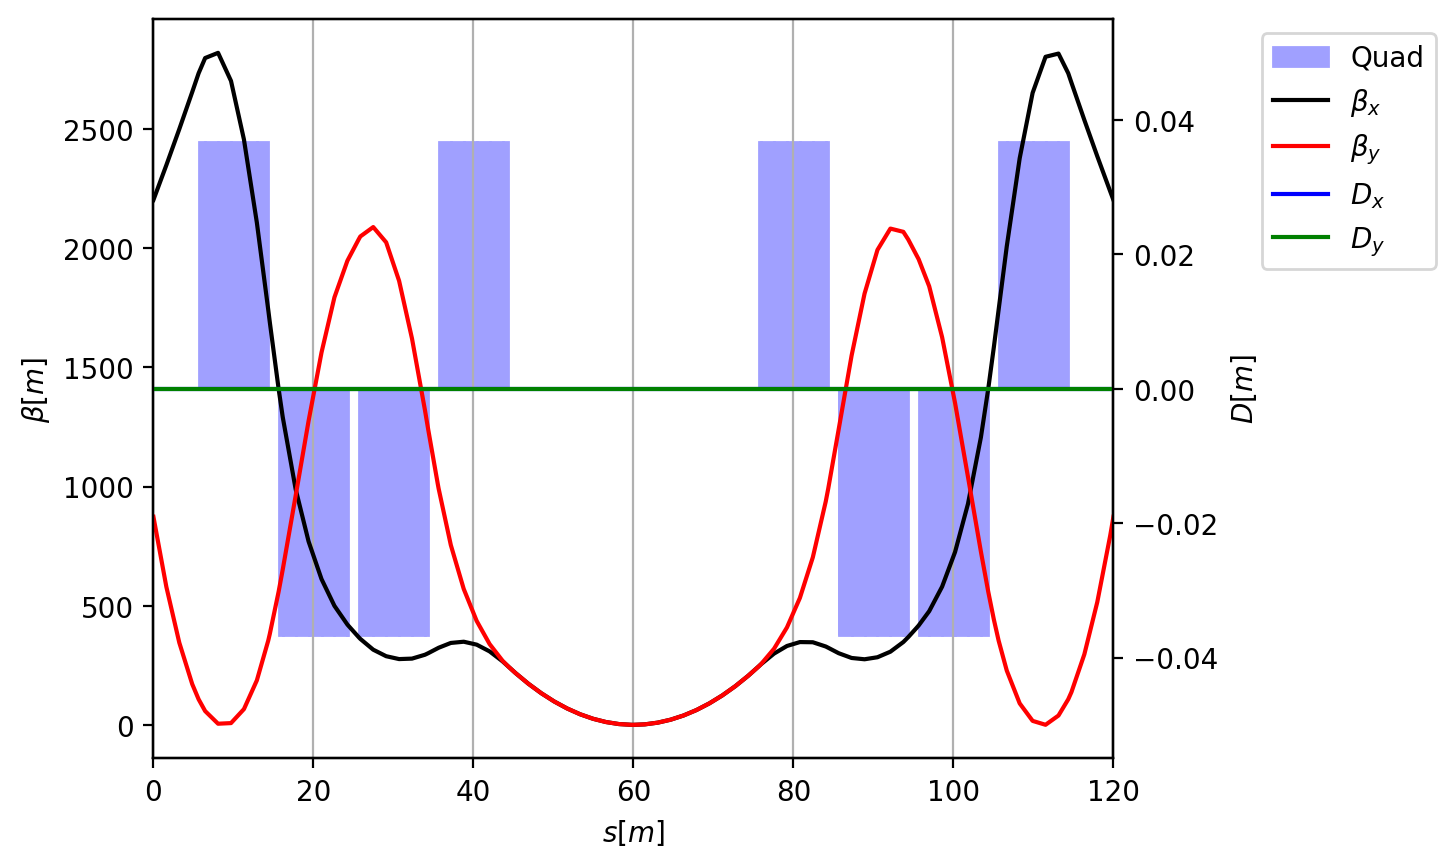

In [19]:
f(-12, 8.7, 1)

### Anti-symmetric triplet

In [41]:
def f(f, l_quad, beta0):
    k1= 1/f/l_quad
    line = env.new_line(name='myline', components=[
    env.new('start', xt.Marker, at = -60, from_ ='ip'),
    env.new('q3l', xt.Quadrupole, length=l_quad, k1=-k1, at=-50, from_ ='ip'),  # Create an element
    env.new('q2bl', xt.Quadrupole, length=l_quad, k1=k1, at=-40, from_ ='ip'),  # Create an element
    env.new('q2al', xt.Quadrupole, length=l_quad, k1=k1, at=-30, from_ ='ip'),  # Create an element
    env.new('q1l', xt.Quadrupole, length=l_quad, k1=-k1, at=-20, from_ ='ip'),
    env.new('ip', xt.Marker, at = 60),
    env.new('q1r', xt.Quadrupole, length=l_quad, k1=k1, at=20, from_ ='ip'),  # Create an element
    env.new('q2ar', xt.Quadrupole, length=l_quad, k1=-k1, at=30, from_ ='ip'),  # Create another element
    env.new('q2br', xt.Quadrupole, length=l_quad, k1=-k1, at=40, from_ ='ip'),  # Create another element
    env.new('q3r', xt.Quadrupole, length=l_quad, k1=k1, at=50, from_ ='ip'),  # Create another element

    env.new('end', xt.Marker, at=60, from_ ='ip')  # Create another element
     ])
    line.particle_ref = xt.Particles(p0c=7e12, mass0=xt.PROTON_MASS_EV) 
    
    half_twiss = line.twiss4d(betx=beta0, bety=beta0, start='ip', end='end')
    line.cut_at_s(np.linspace(0, 160, 100))
    
    line.twiss4d(bety=half_twiss['betx','end'], 
                betx=half_twiss['bety','end'], 
                alfy=-half_twiss['alfx','end'],
                alfx=-half_twiss['alfy','end'],).plot()
    plt.show()

interactive_plot = interactive(f, f=(10, 100, 1), l_quad=(0.1 ,10,.1),beta0=(1,2,.01),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '550px'
interactive_plot

interactive(children=(IntSlider(value=55, description='f', min=10), FloatSlider(value=5.0, description='l_quad…

Slicing line:   0%|          | 0/21 [00:00<?, ?it/s]

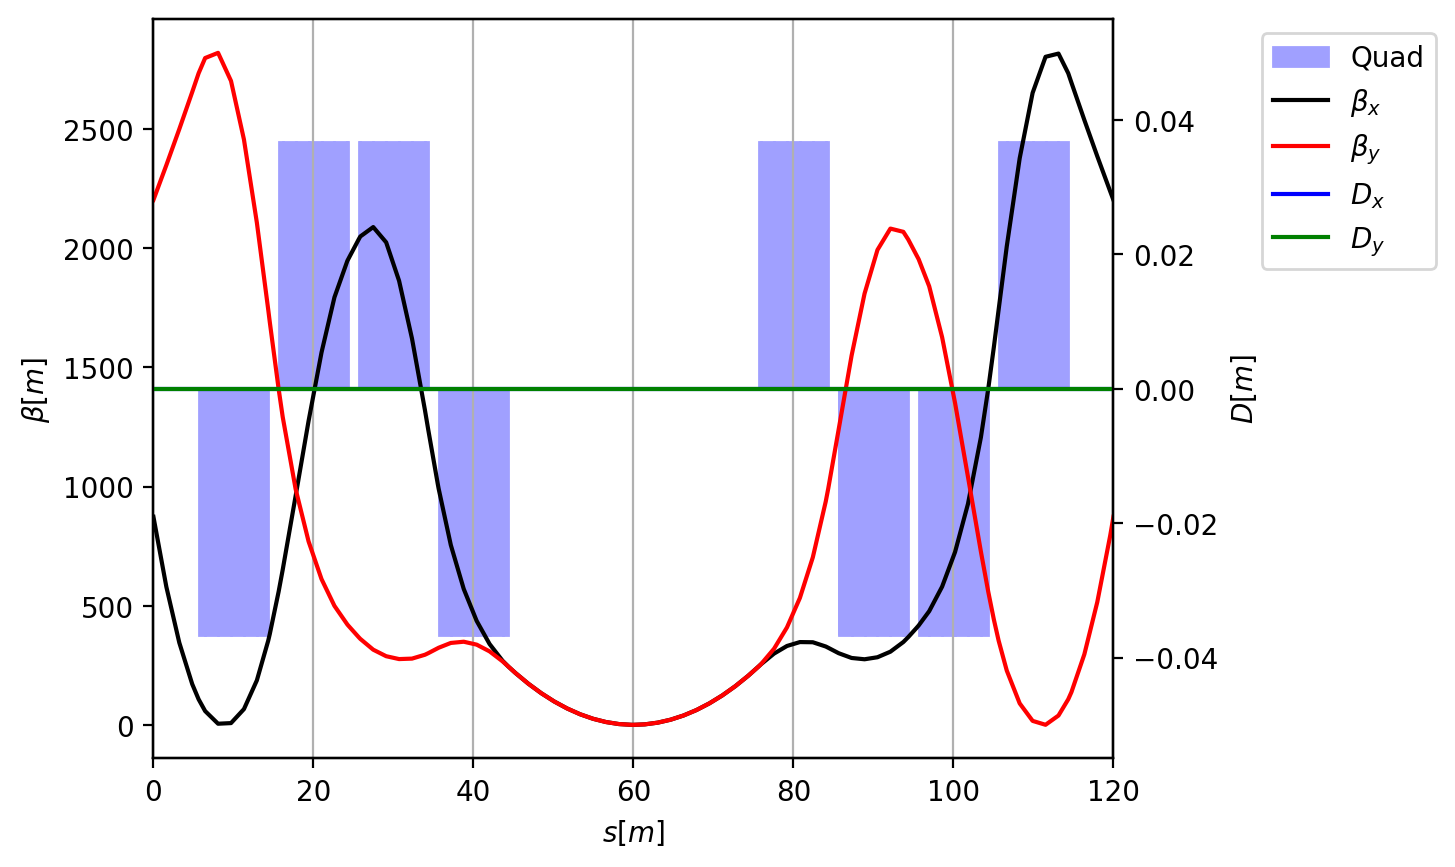

In [42]:
f(12, 8.7, 1)

Slicing line:   0%|          | 0/21 [00:00<?, ?it/s]

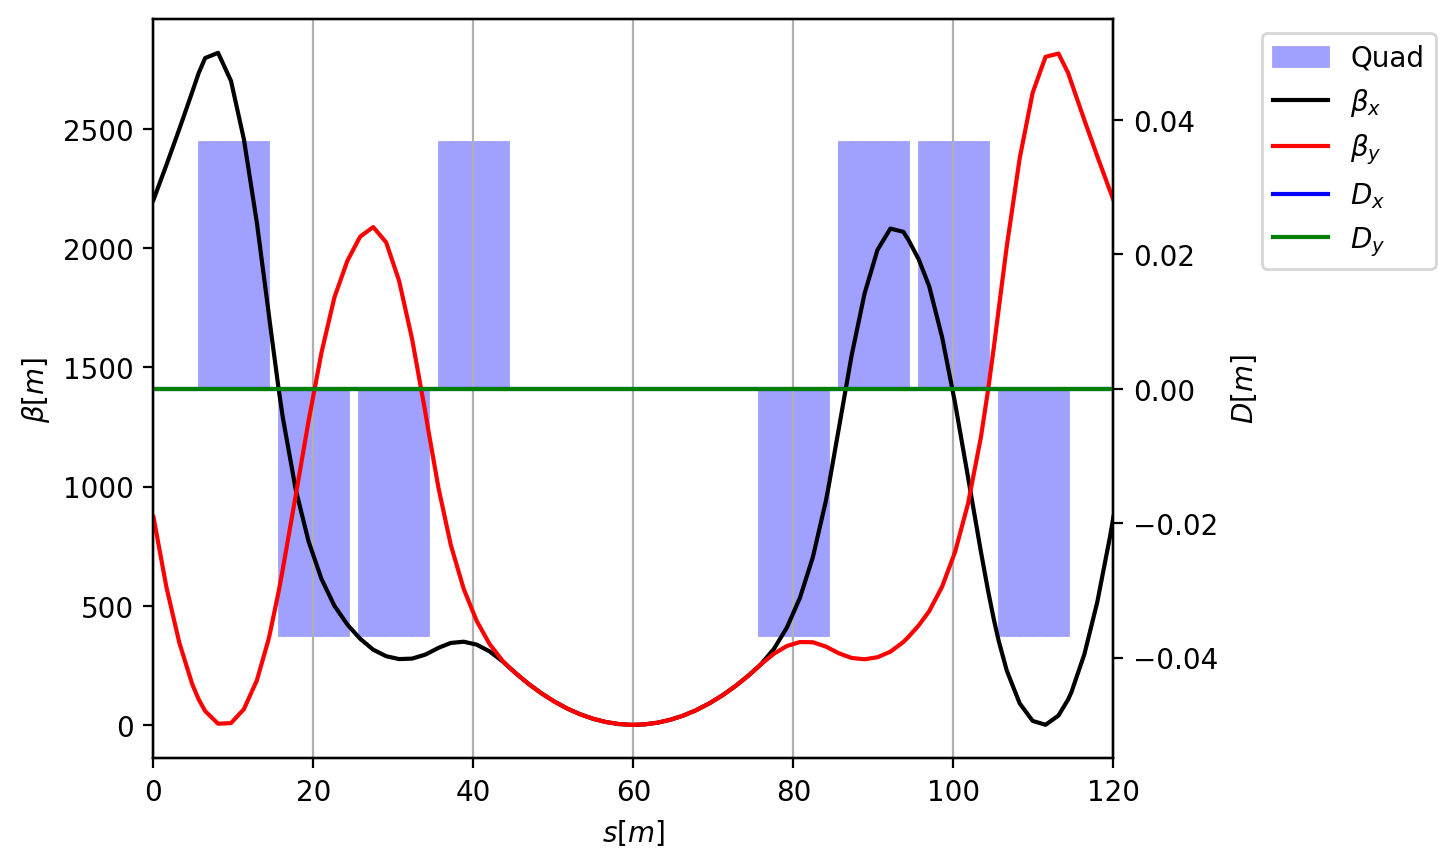

In [22]:
f(-12, 8.7, 1)

Slicing line:   0%|          | 0/21 [00:00<?, ?it/s]

Text(0, 0.5, 'Beam sizes [um]')

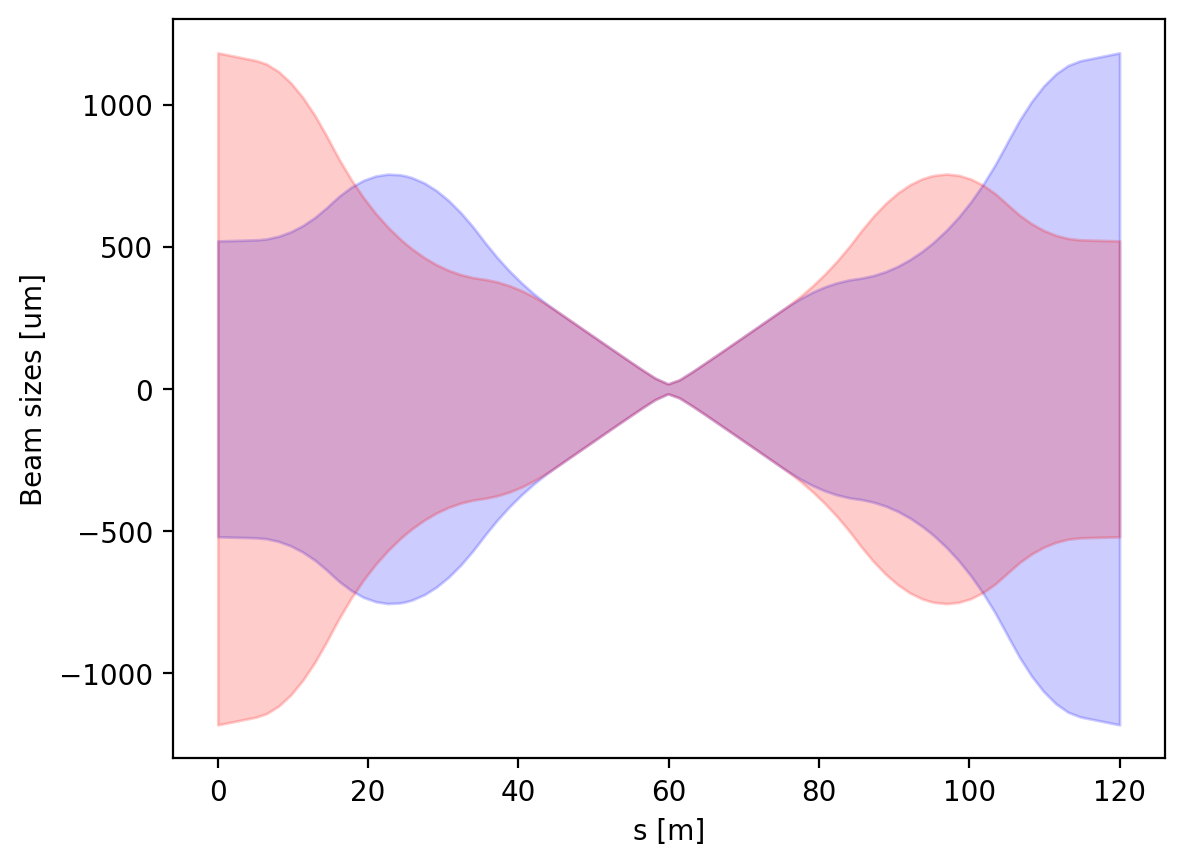

In [43]:
f = 23
l_quad = 9.8
beta0 = 1
k1= 1/f/l_quad
line = env.new_line(name='myline', components=[
env.new('start', xt.Marker, at = -60, from_ ='ip'),
env.new('q3l', xt.Quadrupole, length=l_quad, k1=-k1, at=-50, from_ ='ip'),  # Create an element
env.new('q2bl', xt.Quadrupole, length=l_quad, k1=k1, at=-40, from_ ='ip'),  # Create an element
env.new('q2al', xt.Quadrupole, length=l_quad, k1=k1, at=-30, from_ ='ip'),  # Create an element
env.new('q1l', xt.Quadrupole, length=l_quad, k1=-k1, at=-20, from_ ='ip'),
env.new('ip', xt.Marker, at = 60),
env.new('q1r', xt.Quadrupole, length=l_quad, k1=k1, at=20, from_ ='ip'),  # Create an element
env.new('q2ar', xt.Quadrupole, length=l_quad, k1=-k1, at=30, from_ ='ip'),  # Create another element
env.new('q2br', xt.Quadrupole, length=l_quad, k1=-k1, at=40, from_ ='ip'),  # Create another element
env.new('q3r', xt.Quadrupole, length=l_quad, k1=k1, at=50, from_ ='ip'),  # Create another element

env.new('end', xt.Marker, at=60, from_ ='ip')  # Create another element
 ])
line.particle_ref = xt.Particles(p0c=7e12, mass0=xt.PROTON_MASS_EV) 

half_twiss = line.twiss4d(betx=beta0, bety=beta0, start='ip', end='end')
line.cut_at_s(np.linspace(0, 160, 100))

my_twiss = line.twiss4d(bety=half_twiss['betx','end'], 
            betx=half_twiss['bety','end'], 
            alfy=-half_twiss['alfx','end'],
            alfx=-half_twiss['alfy','end'],)


# Transverse normalized emittances
nemitt_x = 2.5e-6
nemitt_y = 2.5e-6

# Longitudinal emittance from energy spread
sigma_pzeta = 2e-4
gemitt_zeta = sigma_pzeta**2 *1
# similarly, if the bunch length is known, the emittance can be computed as
# gemitt_zeta = sigma_zeta**2 / tw.bets0

beam_sizes = my_twiss.get_beam_covariance(nemitt_x=nemitt_x,
                                nemitt_y=nemitt_y,
                                gemitt_zeta=gemitt_zeta)


# fill region between the two curves
plt.fill_between(beam_sizes['s'], beam_sizes['sigma_x']*1e6, -beam_sizes['sigma_x']*1e6, color='b', alpha=0.2)
plt.fill_between(beam_sizes['s'], beam_sizes['sigma_y']*1e6, -beam_sizes['sigma_y']*1e6, color='r', alpha=0.2)
plt.xlabel('s [m]')
plt.ylabel('Beam sizes [um]')

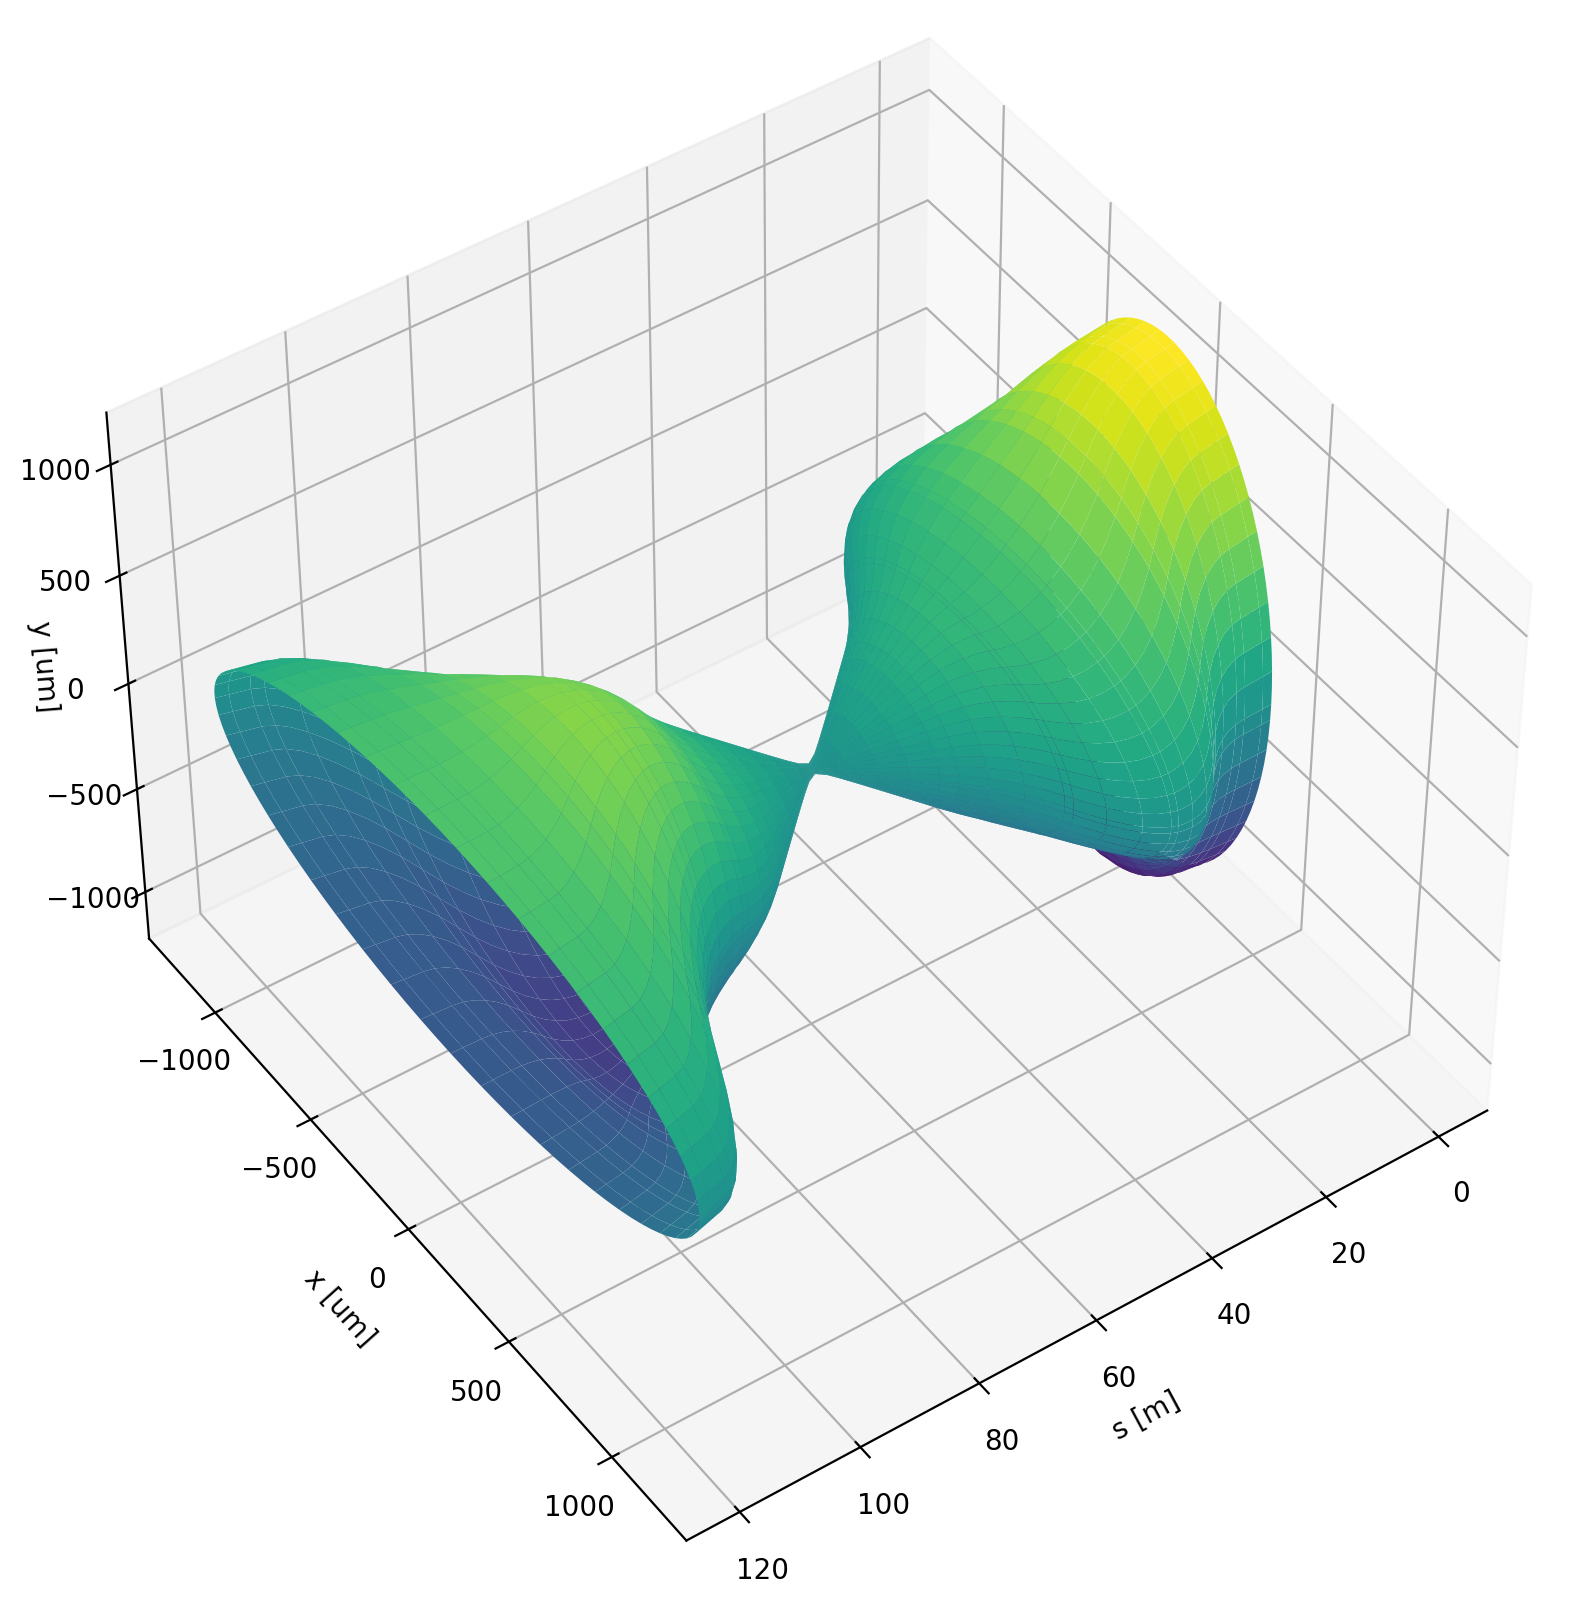

In [44]:
from mpl_toolkits.mplot3d import Axes3D

# Define the range of s
s = beam_sizes.s  # Longitudinal position

# Define sigma_x(s) and sigma_y(s) as functions or arrays
sigma_x = beam_sizes.sigma_x*1e6
sigma_y = beam_sizes.sigma_y*1e6

# Create a meshgrid for theta (angle around the envelope)
theta = np.linspace(0, 2 * np.pi, 100)

# Create the 3D arrays for plotting
S, T = np.meshgrid(s, theta)  # Meshgrid for s and theta

# Parametric equations for the 3D envelope
X = sigma_x * np.cos(T)  # X in the horizontal plane
Y = sigma_y * np.sin(T)  # Y in the vertical plane
Z = S  # Z is the longitudinal axis

# Create the 3D plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface representing the 3D envelope
ax.plot_surface(Z, X, Y, cmap='viridis', alpha=1, shade=True)

# Labels for axes
ax.set_xlabel('s [m]')
ax.set_ylabel('x [um]')
ax.set_zlabel('''y [um]\n\n''')
ax.view_init(elev=45, azim=55)
# Show the plot
plt.show()

# Telescopic squeeze

By controlling the $\beta$-function at the entrance of the triplet one can adjust the $\beta$-function at s=0 without trimming the final focusing quadrupoles: this is the so-called telescopic squeeze.

In [45]:
def f(f, l_quad, beta0):
    k1= 1/f/l_quad
    line = env.new_line(name='myline', components=[
    env.new('start', xt.Marker, at = -60, from_ ='ip'),
    env.new('q3l', xt.Quadrupole, length=l_quad, k1=-k1, at=-50, from_ ='ip'),  # Create an element
    env.new('q2bl', xt.Quadrupole, length=l_quad, k1=k1, at=-40, from_ ='ip'),  # Create an element
    env.new('q2al', xt.Quadrupole, length=l_quad, k1=k1, at=-30, from_ ='ip'),  # Create an element
    env.new('q1l', xt.Quadrupole, length=l_quad, k1=-k1, at=-20, from_ ='ip'),
    env.new('ip', xt.Marker, at = 60),
    env.new('q1r', xt.Quadrupole, length=l_quad, k1=k1, at=20, from_ ='ip'),  # Create an element
    env.new('q2ar', xt.Quadrupole, length=l_quad, k1=-k1, at=30, from_ ='ip'),  # Create another element
    env.new('q2br', xt.Quadrupole, length=l_quad, k1=-k1, at=40, from_ ='ip'),  # Create another element
    env.new('q3r', xt.Quadrupole, length=l_quad, k1=k1, at=50, from_ ='ip'),  # Create another element

    env.new('end', xt.Marker, at=60, from_ ='ip')  # Create another element
     ])
    line.particle_ref = xt.Particles(p0c=7e12, mass0=xt.PROTON_MASS_EV) 
    
    half_twiss = line.twiss4d(betx=beta0, bety=beta0, start='ip', end='end')
    line.cut_at_s(np.linspace(0, 160, 100))
    
    return line.twiss4d(bety=half_twiss['betx','end'], 
                betx=half_twiss['bety','end'], 
                alfy=-half_twiss['alfx','end'],
                alfx=-half_twiss['alfy','end'],)
    
betx=[]
bety=[]
alfx=[]
alfy=[]

for i in np.arange(1,11,1):
    aux=f(f=14, l_quad=3.20, beta0=i)
    betx.append(aux['betx','start'])
    bety.append(aux['bety','start'])
    alfx.append(aux['alfx','start'])
    alfy.append(aux['alfy','start'])

Slicing line:   0%|          | 0/21 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/21 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/21 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/21 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/21 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/21 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/21 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/21 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/21 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/21 [00:00<?, ?it/s]

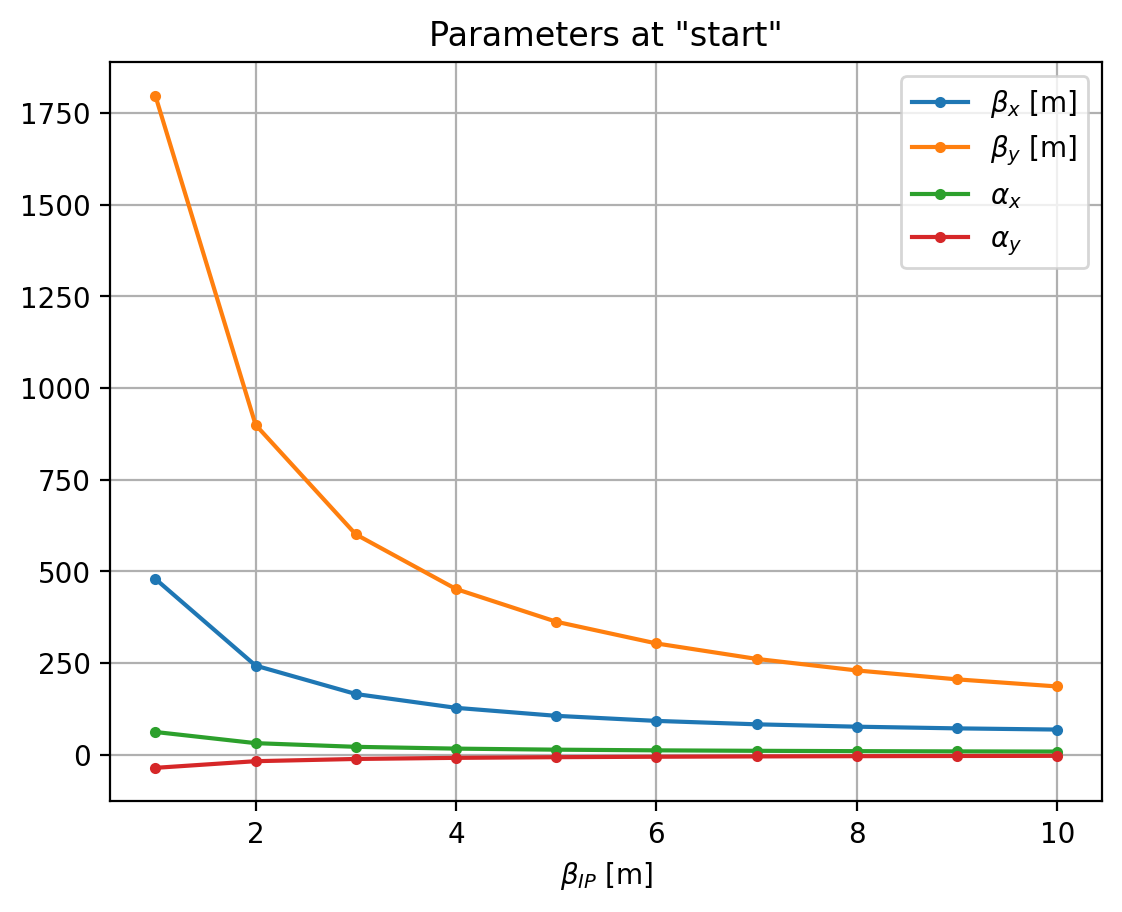

In [26]:
beta0=np.arange(1,11,1)
plt.plot(beta0,betx,'.-',label='$\\beta_x$ [m]')
plt.plot(beta0,bety,'.-',label='$\\beta_y$ [m]')
plt.plot(beta0,alfx,'.-',label='$\\alpha_x$')
plt.plot(beta0,alfy,'.-',label='$\\alpha_y$')
plt.grid()
plt.xlabel('$\\beta_{IP}$ [m]')
plt.title('Parameters at "start"')
plt.legend(loc='best')
